In [50]:
import os
import time
import csv
import subprocess
import psutil
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import featuretools as ft
import dtale
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder

from boruta import BorutaPy

from fancyimpute import KNN
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay


import category_encoders as ce

import sweetviz as sv

import xgboost as xgb
import optuna
import optuna.visualization as vis

import streamlit as st
import matplotlib.pyplot as plt


In [51]:
### Step 1: Use dtale to look into missing values

df = pd.read_csv("StudentsPerformance.csv")

## Create a high cardinality categorical variable:

df['highcard'] =  np.random.choice([f'Category_{i}' for i in range(1, 30)], size=len(df))

### Replace special characters and spaces in dataframe
df.columns = df.columns.str.replace(r'[^A-Za-z0-9]+', '_', regex=True)

df.head()


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,highcard
0,female,group B,bachelor's degree,standard,none,72.0,72,74.0,Category_8
1,female,group C,some college,standard,completed,69.0,90,88.0,Category_26
2,female,group B,master's degree,standard,none,90.0,95,93.0,Category_14
3,male,group A,associate's degree,free/reduced,none,47.0,57,44.0,Category_6
4,male,group C,some college,standard,none,76.0,78,75.0,Category_6


In [52]:
### Save a sweetviz report to analyze graphs. 

report = sv.analyze(df)
report.show_html("sweetviz_report.html")


                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [53]:
### Step 2: Use fancyimpute and sklearn.SimpleImpute


## Select the categorical and numeric variables
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

## First the numeric variables are filled
df_numeric = pd.DataFrame(KNN(k=3).fit_transform(df[numeric_cols]), columns=numeric_cols)


## Next fill the categorical variables
cat_imputer = SimpleImputer(strategy='most_frequent')
df_categorical = pd.DataFrame(cat_imputer.fit_transform(df[categorical_cols]), columns=categorical_cols)


df_imputed = pd.concat([df_numeric, df_categorical], axis=1)
df_imputed.head()


Imputing row 1/1000 with 0 missing, elapsed time: 0.071
Imputing row 101/1000 with 0 missing, elapsed time: 0.071
Imputing row 201/1000 with 0 missing, elapsed time: 0.071
Imputing row 301/1000 with 0 missing, elapsed time: 0.071
Imputing row 401/1000 with 0 missing, elapsed time: 0.071
Imputing row 501/1000 with 0 missing, elapsed time: 0.072
Imputing row 601/1000 with 0 missing, elapsed time: 0.072
Imputing row 701/1000 with 0 missing, elapsed time: 0.072
Imputing row 801/1000 with 0 missing, elapsed time: 0.072
Imputing row 901/1000 with 0 missing, elapsed time: 0.072


,math_score,reading_score,writing_score,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,highcard
0,72.0,72.0,74.0,female,group B,bachelor's degree,standard,none,Category_8
1,69.0,90.0,88.0,female,group C,some college,standard,completed,Category_26
2,90.0,95.0,93.0,female,group B,master's degree,standard,none,Category_14
3,47.0,57.0,44.0,male,group A,associate's degree,free/reduced,none,Category_6
4,76.0,78.0,75.0,male,group C,some college,standard,none,Category_6


In [54]:
### Next, encode categorical variables 


##  manually specify them if you need to use a target_encoder separately: 
categorical_columns = ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course']

## Use this code to pull categorical columns
categorical_columns = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

## Highlight all the high cardinality columns
highcard = ['highcard']


## Use a rarelabelencoder for high cardinality. This way we're not generating too many variables 
encoder = RareLabelEncoder(
    tol=0.04,         # Minimum frequency a category must have to remain (5% in this case)
    n_categories=1,   # Ensures only one "Other" category is created
    replace_with='Other',  # Label for grouped categories
    variables=highcard  # Column to apply encoding
)

df_encoded = encoder.fit_transform(df_imputed)

## Initialize categorical encoder for all categorical variables
encoder = ce.OneHotEncoder(cols=categorical_columns, use_cat_names=True)
df_encoded = encoder.fit_transform(df_encoded)





In [55]:
### Deal with outliers

## Setup the isolationforest 
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df_encoded)

df_encoded['Outlier'] = outliers
df_inliers = df_encoded[df_encoded['Outlier'] == 1].drop(columns='Outlier')
df_inliers.head()


,math_score,reading_score,writing_score,gender_female,gender_male,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group A,race_ethnicity_group D,race_ethnicity_group E,...,test_preparation_course_none,test_preparation_course_completed,highcard_Category_8,highcard_Other,highcard_Category_4,highcard_Category_1,highcard_Category_9,highcard_Category_3,highcard_Category_18,highcard_Category_5
0,72.0,72.0,74.0,1,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,69.0,90.0,88.0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,90.0,95.0,93.0,1,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
3,47.0,57.0,44.0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
4,76.0,78.0,75.0,0,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [56]:
### Use Boruta
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
boruta_selector = BorutaPy(rf, n_estimators='auto', alpha=0.01,max_iter=200,perc=80) ### Lower alpha to select fewer variables


### Select X and y and do the train test split
y_col_name = 'writing_score'
y = df_inliers[y_col_name]
X= df_inliers.drop(y_col_name,axis=1)


boruta_selector.fit(X.values, y)
selected_features = X.columns[boruta_selector.support_].tolist()
print("Selected Features:", selected_features)

X_sel = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)



Selected Features: ['math_score', 'reading_score', 'gender_female', 'gender_male', 'race_ethnicity_group D', 'parental_level_of_education_some high school', 'test_preparation_course_none', 'test_preparation_course_completed']


In [57]:
### Use XGboost:

## Can define an MAE objective function: 
def custom_mae(y_true, y_pred):
    gradient = np.sign(y_pred - y_true)  # Gradient (first derivative) of MAE
    hessian = np.ones_like(y_true)       # Hessian (second derivative) is constant for MAE
    return gradient, hessian

#Use this for MSE
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',  # Specifies regression with squared error
    n_estimators=100,              # Number of boosting rounds
    learning_rate=0.1,             # Step size shrinkage
    max_depth=4,                   # Maximum depth of trees
    random_state=42
)

#Use this for MAE
xgb_reg_mae = xgb.XGBRegressor(
    objective=custom_mae,  # Specifies regression with squared error
    n_estimators=100,              # Number of boosting rounds
    learning_rate=0.1,             # Step size shrinkage
    max_depth=4,                   # Maximum depth of trees
    random_state=42
)

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 4.266257078535413


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

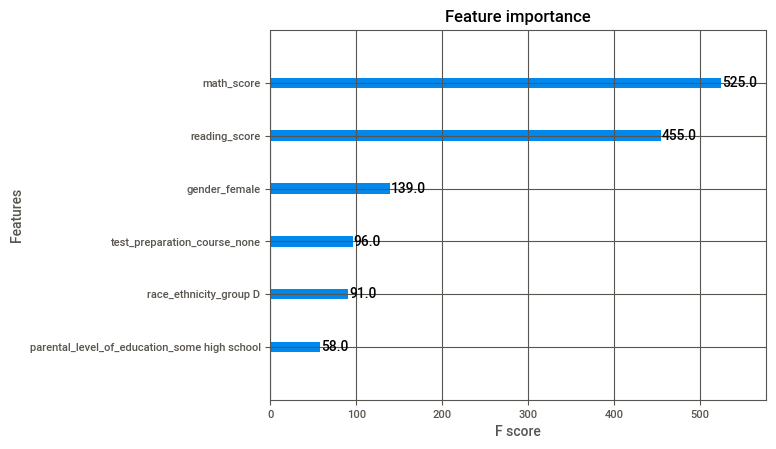

In [58]:
xgb.plot_importance(xgb_reg)


In [59]:
### Use Optuna with XGBoost to tune hyperparameters

def objective(trial):
    # Define the parameter search space
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-2, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-2, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Train the XGBoost model with the current set of parameters
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)],  verbose=False)

    # Make predictions and evaluate
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds)

    return rmse

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=200)  # Adjust n_trials as needed

# Print the best hyperparameters and the best RMSE
print("Best RMSE:", study.best_value)
print("Best Hyperparameters:", study.best_params)

[I 2024-11-15 11:29:58,434] A new study created in memory with name: no-name-40f0ecee-e4b7-4786-b1bb-1df7bc0fd1de
[I 2024-11-15 11:29:58,690] Trial 0 finished with value: 28.556198930790522 and parameters: {'lambda': 0.7140404036681042, 'alpha': 0.5449199210952227, 'learning_rate': 0.2527004766260615, 'n_estimators': 917, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.9034031931396868, 'subsample': 0.5636826964092161, 'colsample_bytree': 0.8069543240632112}. Best is trial 0 with value: 28.556198930790522.
[I 2024-11-15 11:29:58,800] Trial 1 finished with value: 23.873138268449285 and parameters: {'lambda': 0.5377514590436782, 'alpha': 0.10579401427890531, 'learning_rate': 0.19993869407751805, 'n_estimators': 278, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.25446344740819105, 'subsample': 0.8796697301568599, 'colsample_bytree': 0.6260558962494269}. Best is trial 1 with value: 23.873138268449285.
[I 2024-11-15 11:29:58,852] Trial 2 finished with value: 24.715469959145985 and par

Best RMSE: 16.526199944402432
Best Hyperparameters: {'lambda': 0.7776946242221539, 'alpha': 0.4553279819096448, 'learning_rate': 0.02390507472130109, 'n_estimators': 621, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 0.1378095176970795, 'subsample': 0.7800693697922976, 'colsample_bytree': 0.6487508258936652}


C:\Users\mohda\AppData\Local\Temp\ipykernel_38612\1528109834.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




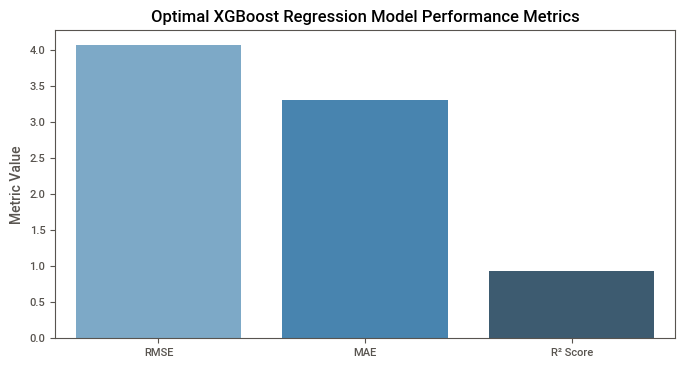

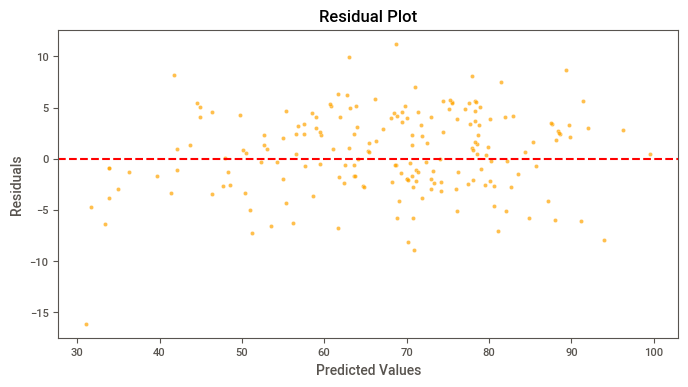

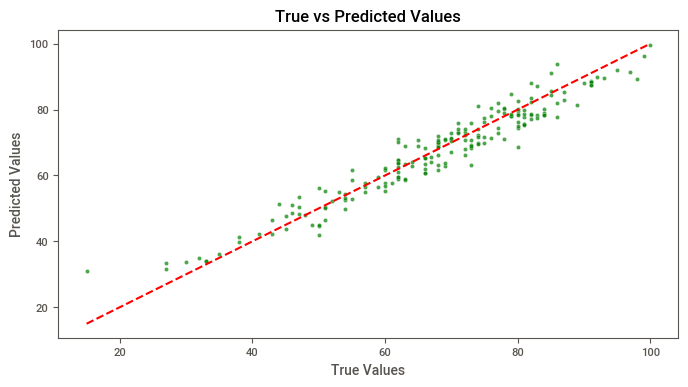

In [60]:
### Display model performance metrics with the best hyperparameters. 
best_params = study.best_params
optimal_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse')
optimal_model.fit(X_train, y_train)

### use this optimal model to predict
y_pred = optimal_model.predict(X_test)


### get model performance metrics for this model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


### Visualize metrics
metrics = {'RMSE': rmse, 'MAE': mae, 'R² Score': r2}
plt.figure(figsize=(8, 4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
plt.title("Optimal XGBoost Regression Model Performance Metrics")
plt.ylabel("Metric Value")
plt.show()

### Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, color="orange")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

### True vs Predicted scatter plot
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()


In [61]:
##### Use this code for a classifier
#######

# # Use the best hyperparameters from Optuna
# best_params = study.best_params
# optimal_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
# optimal_model.fit(X_train, y_train)

# # Use this optimal model to predict
# y_pred = optimal_model.predict(X_test)  # Predicted class labels
# y_proba = optimal_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# # Get classification performance metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_proba)

# # Visualize metrics
# metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC AUC': roc_auc}
# plt.figure(figsize=(8, 4))
# sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
# plt.title("Optimal XGBoost Classification Model Performance Metrics")
# plt.ylabel("Metric Value")
# plt.ylim(0, 1)  # Metrics are probabilities, so range is [0, 1]
# plt.show()

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=optimal_model.classes_)
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix")
# plt.show()

# # ROC Curve
# fpr, tpr, _ = roc_curve(y_test, y_proba)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
# plt.plot([0, 1], [0, 1], color='red', linestyle='--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend(loc="lower right")
# plt.show()

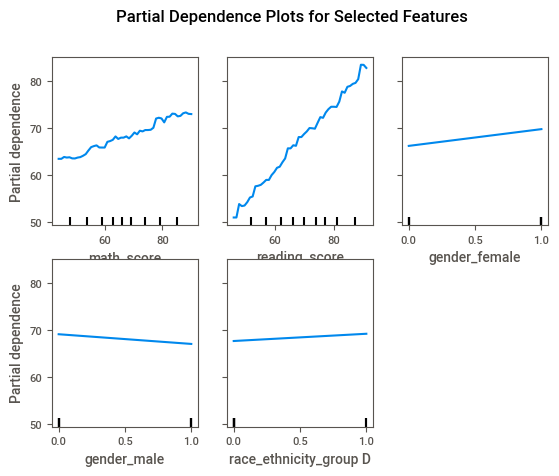

In [62]:
### Plot partial dependance plots 
features_to_plot = selected_features[:5]  # Limit to top 5 features for visualization
feature_indices = [X_train.columns.get_loc(col) for col in features_to_plot]  # Get column indices for selected features

# Plot PDPs
PartialDependenceDisplay.from_estimator(
    optimal_model, X_train, features=feature_indices, grid_resolution=50
)
plt.suptitle("Partial Dependence Plots for Selected Features")
plt.show()

In [14]:
### Check optimization history plot
vis.plot_optimization_history(study)


In [15]:
vis.plot_param_importances(study)


In [ ]:
### Use streamlit

st.title("Simple Data Explorer")
uploaded_file = st.file_uploader("", type="csv")


